In [12]:
"""
import modules
"""
from prepare_data import prepare_df_from_mac_5_year as prepare_data
from prepare_data import filter_IAMC as IAMC
from emulate_reduction import emulator_v3 as emulate
from visualize_output import vis_emulator_v1 as v1_plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

dir(emulate)

['CtaxRedEmulator',
 'Lasso',
 'LinearRegression',
 'PolynomialFeatures',
 'Ridge',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'mean_squared_error',
 'minimize',
 'np',
 'pd',
 'plt',
 'r2_score',
 'train_test_split',
 'tree']

In [2]:
"""
load data
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

# new paths, from IAMC databese
IAMC_database = pd.read_excel(PATH_IAMC + FILENAME_IAMC, sheet_name='data')

,Model,Scenario,Region,Variable,Unit,2000,2001,2002,2003,2004,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,POLES EMF33,EMF33_1.5C_nofuel,World,AR5 climate diagnostics|Temperature|Global Mea...,°C,0.711019,0.737667,0.759933,0.776514,0.790307,...,1.085518,1.077835,1.070139,1.061901,1.053525,1.044592,1.035311,1.025724,1.016270,1.007517
1,POLES EMF33,EMF33_1.5C_cost100,World,AR5 climate diagnostics|Temperature|Global Mea...,°C,0.711019,0.737667,0.759933,0.776514,0.790307,...,1.113634,1.104639,1.097199,1.088984,1.079463,1.070013,1.062711,1.054574,1.043686,1.033555
2,POLES EMF33,EMF33_1.5C_full,World,AR5 climate diagnostics|Temperature|Global Mea...,°C,0.711019,0.737667,0.759933,0.776514,0.790307,...,1.125549,1.115321,1.105552,1.097184,1.087589,1.079007,1.071059,1.063645,1.054268,1.043041
3,C-ROADS-5.005,Ratchet-1.5-limCDR-noOS,World,AR5 climate diagnostics|Temperature|Global Mea...,°C,0.711019,0.737667,0.759933,0.776514,0.790307,...,1.110535,1.105657,1.101463,1.097816,1.094392,1.091183,1.088049,1.084718,1.082278,1.079652
4,REMIND-MAgPIE 1.7-3.0,SMP_1p5C_Sust,World,AR5 climate diagnostics|Temperature|Global Mea...,°C,0.711019,0.737667,0.759933,0.776514,0.790307,...,1.186884,1.180336,1.173566,1.166503,1.159969,1.153981,1.148209,1.142262,1.136662,1.130934


           2020        2030         2040         2050         2060  \
0      0.000000   20.800265    92.612201    62.540649   101.781152   
1      0.000000   16.379844    47.895859    30.576344    45.723945   
2      0.000000   75.000000   150.000000   172.500000   182.000000   
3     13.680000  111.359998   160.000000   172.500000   182.000000   
4     13.680000  111.359998   160.000000   172.500000   182.000000   
..          ...         ...          ...          ...          ...   
795  137.209645  586.880155  2285.488209  2285.488209  2285.488209   
796  120.836965  518.379559  1664.301333  1664.301333  1748.965001   
797   95.191703  586.390347  2169.908658  2169.908658  2811.822778   
798   87.686814  523.232704  3778.458762  3813.224405  3813.224405   
799  101.586328  443.357299  1768.655403  1768.655403  1768.655403   

            2070         2080         2090    2100  
0     138.560803   174.628650   183.218652   200.0  
1     109.367608   157.394154   184.939342   200.0  


C:\Users\toonv\Documents\PBL\Code\Emulator\prepare_data\filter_IAMC.py:59: RuntimeWarning: invalid value encountered in true_divide
  norm_ctax = self.values_only.values / final_ctax[:, None]


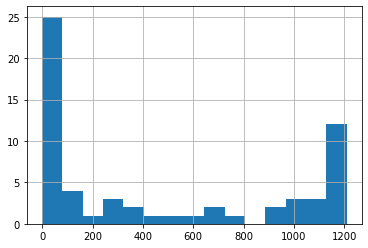

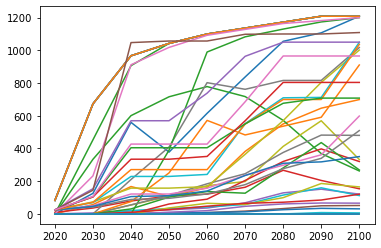

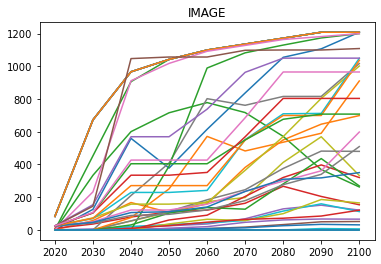

In [220]:
reload(IAMC)

YEAR_STEP = 10
MAX_CTAX = 4000
BINS = 15
MODELS = ['IMAGE']
STEP_CTAX = 200

raw_data = IAMC.IAMC(IAMC_database)

carbon_prices, models_ctax = raw_data.filter_iamc(year_step, 'Price|Carbon', MAX_CTAX, MODELS)
# mean_temp, models_temp = raw_data.filter_iamc(year_step, 'AR5 climate diagnostics|Temperature|Global Mean|MAGICC6|MED',
#                                               MAX_CTAX, MODELS)

carbon_prices['2100'].hist(bins=BINS)
raw_data.plot_iamc(carbon_prices)

# scale ctax
raw_data.scale_ctax(STEP_CTAX)
raw_data.prepare_mym()



In [ ]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2060
region = 11
TIMERSTEP = 5
test_size = 0.1
stepsize_ctax_paths = 10
number_of_weights = 2

In [ ]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_data)

lin_reduction = prepare_data.reduction_df(df_linear, year, region)
cubic_reduction = prepare_data.reduction_df(df_cubic, year, region)
root_reduction = prepare_data.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_data.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_data.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_data.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

combi.tail()

In [ ]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, cubic_paths, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
x.test_ctax_paths() 


In [ ]:
reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, combi, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
multi_lin_plot = x.test_regr(multi_lin_regr_mod)

# polynomial regression model
degree = 3
poly_regr_mod = x.train_ctax_PR(degree)
poly_regr_plot = x.test_regr(poly_regr_mod)

# Ridge regression
alpha = 1
ridge_mod = x.train_ctax_ridge(alpha)
ridge_plot = x.test_regr(ridge_mod)

# lasso regression
alpha = 1
lasso_mod = x.train_ctax_lasso(alpha)
lasso_plot = x.test_regr(lasso_mod)

# regression tree
max_depth = 5
regr_tree = x.train_ctax_tree(max_depth)
tree_plot = x.test_regr(regr_tree)
